In [1]:
#
# Weakly supervised learning,
# CNN-GlobalAveragePooling MNIST
#
# @author becxer
# @email becxer87@gmail.com
# @reference https://github.com/sjchoi86/Tensorflow-101
#

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline  

print ("packages are loaded")

packages are loaded


In [2]:
# Get MNIST data set from tensorflow
from tensorflow.examples.tutorials.mnist import input_data
mnist_set = input_data.read_data_sets('images/MNIST/', one_hot = True)

train_img = mnist_set.train.images
train_label = mnist_set.train.labels
test_img = mnist_set.test.images
test_label = mnist_set.test.labels

Extracting mnist/train-images-idx3-ubyte.gz
Extracting mnist/train-labels-idx1-ubyte.gz
Extracting mnist/t10k-images-idx3-ubyte.gz
Extracting mnist/t10k-labels-idx1-ubyte.gz


In [4]:
# Options for training
learning_rate = 0.001
training_epochs = 100
batch_size = 100
display_step = 10

# Deviation of weights
w_dev = 0.1

# Options for dropout
drop_out_ratio = 0.7

In [28]:
# Build CNN-GlobalAveragePooling graph

WS = {
    'wc_1' : tf.Variable(tf.random_normal([3,3,1,64], stddev=w_dev)),
    'wc_2' : tf.Variable(tf.random_normal([3,3,64,128], stddev=w_dev)),
    'out'  : tf.Variable(tf.random_normal([128,10],stddev=w_dev))
}

BS = {
    'bc_1' : tf.Variable(tf.random_normal([64], stddev=w_dev)),
    'bc_2' : tf.Variable(tf.random_normal([128], stddev=w_dev)),
    'out' : tf.Variable(tf.random_normal([10], stddev=w_dev))
}

def CNN_GAP(_X,  _W, _B, _dop):
    _X = tf.reshape(_X, [-1,28,28,1])
    
    _conv1 = tf.nn.relu(tf.nn.bias_add(tf.nn.conv2d(_X,_W['wc_1'], strides=[1,1,1,1], padding="SAME"),_B['bc_1']))
    _max_pool1 = tf.nn.max_pool(_conv1, ksize=[1,2,2,1], strides=[1,2,2,1], padding="SAME")
    _do1 = tf.nn.dropout(_max_pool1, _dop)
    
    _gap_conv = tf.nn.relu(tf.nn.bias_add(tf.nn.conv2d(_do1,_W['wc_2'], strides=[1,1,1,1], padding="SAME"),_B['bc_2']))
    _gap_pool = tf.nn.avg_pool(_gap_conv, ksize=[1,14,14,1], strides=[1,14,14,1], padding="SAME")
    _do2 = tf.nn.dropout(_gap_pool, _dop)
    
    _do2_r = tf.reshape(_do2, [-1,128])
    _out = tf.nn.softmax(tf.add(tf.matmul(_do2_r,_W['out']),_B['out']))
    return { 'gap':_gap_conv, 'out':_out }


x = tf.placeholder("float", [None, train_img.shape[1]])
y = tf.placeholder("float", [None, train_label.shape[1]])
drop_out_prob = tf.placeholder("float")

res = CNN_GAP(x, WS, BS, drop_out_prob)

out = res['out']
gap = res['gap']

cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(out, y))
optm = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

pred = tf.argmax(out, 1)
accr = tf.reduce_mean(tf.cast(tf.equal(pred, tf.argmax(y, 1)),"float"))

init = tf.initialize_all_variables()
print ("Graph build")

Graph build


In [29]:
# Training Graph
sess = tf.Session()
sess.run(init)

for epoch in range(training_epochs):
    avg_cost = 0.
    num_batch = int(train_img.shape[0]/batch_size)
    for i in range(num_batch):
        randidx = np.random.randint(train_img.shape[0], size=batch_size)
        batch_xs = train_img[randidx, :]
        batch_ys = train_label[randidx, :]                
            
        sess.run(optm, feed_dict={x: batch_xs, y: batch_ys, drop_out_prob : drop_out_ratio})
        avg_cost += sess.run(cost, feed_dict={x: batch_xs, y: batch_ys, drop_out_prob : 1.})/num_batch
            
    if epoch % display_step == 0:
        train_img_acc = sess.run(accr , ({x: batch_xs, y: batch_ys, drop_out_prob : 1.}))
        print ("epoch: %03d/%03d  ,  cost: %.6f  ,  train_img_acc: %.3f" \
               % (epoch, training_epochs, avg_cost, train_img_acc))

avg_acc = 0.
num_batch_test = int(test_img.shape[0]/batch_size)
for i in range(num_batch_test):
    batch_xs_test = test_img[i * batch_size : (i+1) * batch_size ]
    batch_ys_test = test_label[i * batch_size : (i+1) * batch_size ]            
    avg_acc += sess.run(accr, feed_dict={x : batch_xs_test, y : batch_ys_test, drop_out_prob : 1.})
    
print ("Training complete, Accuracy : %.6f" \
       % (avg_acc / num_batch_test,))

epoch: 000/100  ,  cost: 2.138162  ,  train_img_acc: 0.480
epoch: 010/100  ,  cost: 1.636775  ,  train_img_acc: 0.900
epoch: 020/100  ,  cost: 1.599038  ,  train_img_acc: 0.850
epoch: 030/100  ,  cost: 1.498543  ,  train_img_acc: 0.980
epoch: 040/100  ,  cost: 1.491470  ,  train_img_acc: 0.940
epoch: 050/100  ,  cost: 1.487630  ,  train_img_acc: 0.950
epoch: 060/100  ,  cost: 1.485064  ,  train_img_acc: 0.950
epoch: 070/100  ,  cost: 1.481660  ,  train_img_acc: 1.000
epoch: 080/100  ,  cost: 1.480129  ,  train_img_acc: 0.960
epoch: 090/100  ,  cost: 1.478415  ,  train_img_acc: 0.980
Training complete, Accuracy : 0.983000


/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:5: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future


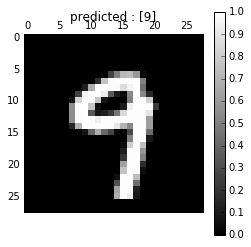

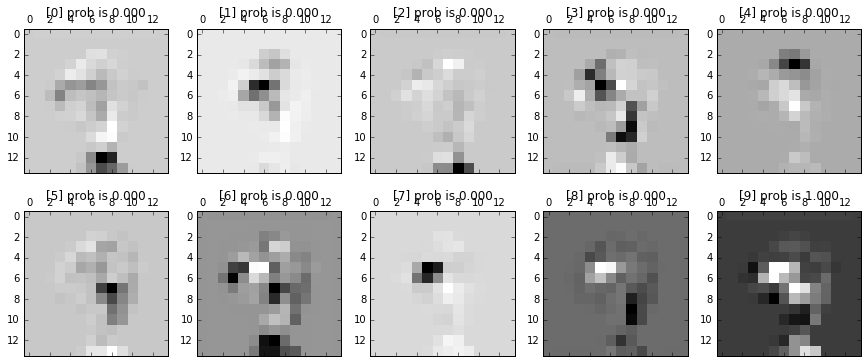

In [40]:
# Observe Nested GAP feature 
rdx = np.random.randint(test_img.shape[0], size=1)

test_x = test_img[rdx,:]
test_y = test_label[rdx:]

test_pred = sess.run(pred,feed_dict={x:test_x,drop_out_prob:1.})
test_out = sess.run(out,feed_dict={x:test_x,drop_out_prob:1.})
test_gap = sess.run(gap,feed_dict={x:test_x,drop_out_prob:1.})
test_w = sess.run(WS['out'])

plt.matshow(np.reshape(test_x,[28,28]), cmap=plt.get_cmap('gray'))
plt.title("predicted : " + str(test_pred))
plt.colorbar()
plt.show()
    
fig, axs = plt.subplots(2, 5, figsize=(15, 6))    
for i in range(10):
    each_gap_w = test_w[:, i:i+1]
    gap_sum = np.zeros((14, 14))
    for j in range(128):
        gap_sum = gap_sum + each_gap_w[j]*test_gap[0, :, :, j]
    gap_avg = gap_sum / 128
    im = axs[int(i/5)][i%5].matshow(gap_avg, cmap=plt.get_cmap('gray'))
    axs[int(i/5)][i%5].set_title(("[%d] prob is %.3f") % (i, test_out[0, i]))

plt.draw()